In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from charset_normalizer import md__mypyc
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet101
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, Flatten, Input, Concatenate
import pickle
from sklearn.preprocessing import OneHotEncoder
from keras import Sequential
from keras.applications.xception import Xception
from keras.layers import BatchNormalization, Activation, Dropout, MaxPooling2D,Conv2D
from tensorflow.keras.layers.experimental import RandomFourierFeatures
import time
import os
from numba import cuda


2023-04-17 17:07:17.878749: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 17:07:18.715100: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/christian/miniconda3/envs/tf/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


Import Training and test data

In [4]:
device = cuda.get_current_device()
device.reset()

CudaAPIError: [2] Call to cuDevicePrimaryCtxRetain results in CUDA_ERROR_OUT_OF_MEMORY

In [3]:
size = 96
num_classes = 16
NUM_EPOCHS = 10

In [4]:
from keras import backend as K

def custom_f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

auc_metric = tf.keras.metrics.AUC(
num_thresholds=200, curve="ROC",
summation_method="interpolation",
thresholds=None, multi_label=False
)


2023-04-13 20:56:27.795903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-13 20:56:27.854106: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-13 20:56:27.854396: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
regularizer = tf.keras.regularizers.l1_l2(0, 0.001)

Change_input_layer, change the input layer to have only 1 channel (black and white). It sets the average of the pre-trained weights for the first layer and for the rest of the layers it uses the same weights.

In [6]:
def change_input_layer(pretrained_model, first_conv, h, w, c):
    pretrained_config = pretrained_model.get_config()

    # Change the input shape from the model
    pretrained_config["layers"][0]["config"]["batch_input_shape"] = (4, h, w, c)

    updated_model = Model.from_config(pretrained_config)


    def avg_weights(weights):
        average_weights = np.mean(weights, axis=-2).reshape(weights[:, :, -1:, :].shape)
        return(average_weights)

    pretrained_updated_config = updated_model.get_config()
    pretrained_updated_layer_names = [pretrained_updated_config['layers'][x]['name'] for x in range(len(pretrained_updated_config['layers']))]
    print(pretrained_updated_layer_names)
    first_conv_name = pretrained_updated_layer_names[first_conv]

    for layer in pretrained_model.layers:
        if layer.name in pretrained_updated_layer_names:
            if layer.get_weights() != []:  #All convolutional layers and layers with weights (no input layer or any pool layers)
                target_layer = updated_model.get_layer(layer.name)
            
                if layer.name in first_conv_name:    #For the first convolutionl layer
                    weights = layer.get_weights()[0]
                    biases  = layer.get_weights()[1]
                    
                    weights_single_channel = avg_weights(weights)
                                                                
                    target_layer.set_weights([weights_single_channel, biases])  #Now set weights for the first conv. layer
                    target_layer.trainable = False   #You can make this trainable if you want. 
            
                else:
                    target_layer.set_weights(layer.get_weights())   #Set weights to all other layers. 
                    target_layer.trainable = False  #You can make this trainable if you want.
    updated_model.summary()
    return updated_model


Simple CNN

VGG16

VGG19

https://github.com/bnsreenu/python_for_microscopists

Resnet

DenseNet

In [7]:
def change_input_layer_dense(pretrained_model, first_conv, h, w, c):
    pretrained_config = pretrained_model.get_config()

    # Change the input shape from the model
    pretrained_config["layers"][0]["config"]["batch_input_shape"] = (4, h, w, c)

    updated_model = Model.from_config(pretrained_config)


    def avg_weights(weights):
        average_weights = np.mean(weights, axis=-2).reshape(weights[:, :, -1:, :].shape)
        return(average_weights)

    pretrained_updated_config = updated_model.get_config()
    pretrained_updated_layer_names = [pretrained_updated_config['layers'][x]['name'] for x in range(len(pretrained_updated_config['layers']))]
    print(pretrained_updated_layer_names)
    first_conv_name = pretrained_updated_layer_names[first_conv]

    for layer in pretrained_model.layers:
        if layer.name in pretrained_updated_layer_names:
            if layer.get_weights() != []:  #All convolutional layers and layers with weights (no input layer or any pool layers)
                target_layer = updated_model.get_layer(layer.name)
            
                if layer.name in first_conv_name:    #For the first convolutionl layer
                    weights = layer.get_weights()[0]
                    
                    weights_single_channel = avg_weights(weights)
                                                                
                    target_layer.set_weights([weights_single_channel])  #Now set weights for the first conv. layer
                    target_layer.trainable = False   #You can make this trainable if you want. 
            
                else:
                    target_layer.set_weights(layer.get_weights())   #Set weights to all other layers. 
                    target_layer.trainable = False  #You can make this trainable if you want.
    updated_model.summary()
    return updated_model

Xception

Training Emotion

In [8]:
import pandas as pd
import numpy as np

CK+

In [9]:
CK_FACS_X_train = pd.read_pickle("./Clean_datasets/CK+/CK+_FACS_X_train")
CK_FACS_y_train = pd.read_pickle("./Clean_datasets/CK+/CK+_FACS_Y_train")
CK_FACS_X_val = pd.read_pickle("./Clean_datasets/CK+/CK+_FACS_X_val")
CK_FACS_y_val = pd.read_pickle("./Clean_datasets/CK+/CK+_FACS_Y_val")

In [10]:
CK_FACS_X_test = pd.read_pickle("./Clean_datasets/CK+/CK+_FACS_X_test")
CK_FACS_y_test = pd.read_pickle("./Clean_datasets/CK+/CK+_FACS_y_test")

FileNotFoundError: [Errno 2] No such file or directory: './Clean_datasets/CK+/CK+_FACS_y_test'

In [10]:
dataset_name = "CK_FACS"

In [11]:
X_train = CK_FACS_X_train
X_val = CK_FACS_X_val
#X_test = CK_FACS_X_test
y_train = CK_FACS_y_train
y_val = CK_FACS_y_val
#y_test = CK_FACS_y_test

EmotioNet

In [9]:
EmotioNet_FACS_X_train = pd.read_pickle("./Clean_datasets/EmotioNet/EmotioNet_FACS_X_train")
EmotioNet_FACS_y_train = pd.read_pickle("./Clean_datasets/EmotioNet/EmotioNet_FACS_Y_train")
EmotioNet_FACS_X_val = pd.read_pickle("./Clean_datasets/EmotioNet/EmotioNet_FACS_X_val")
EmotioNet_FACS_y_val = pd.read_pickle("./Clean_datasets/EmotioNet/EmotioNet_FACS_Y_val")

In [10]:
X_train = EmotioNet_FACS_X_train
X_val = EmotioNet_FACS_X_val
y_train = EmotioNet_FACS_y_train
y_val = EmotioNet_FACS_y_val

In [11]:
dataset_name = "EmotioNet_FACS"

In [44]:
X_train = np.asarray(list(X_train)).astype('float32')

/tmp/ipykernel_15303/2652858062.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train = np.asarray(list(X_train)).astype('float32')


ValueError: setting an array element with a sequence.

MMI

In [9]:
MMI_FACS_X_train = pd.read_pickle("./Clean_datasets/MMI/MMI_FACS_X_train")
MMI_FACS_y_train = pd.read_pickle("./Clean_datasets/MMI/MMI_FACS_Y_train")
MMI_FACS_X_val = pd.read_pickle("./Clean_datasets/MMI/MMI_FACS_X_val")
MMI_FACS_y_val = pd.read_pickle("./Clean_datasets/MMI/MMI_FACS_Y_val")

In [10]:
X_train = MMI_FACS_X_train
X_val = MMI_FACS_X_val
y_train = MMI_FACS_y_train
y_val = MMI_FACS_y_val

In [11]:
dataset_name = "MMI_FACS"

Data pre-processing to fit the models

In [197]:
check_for_nan = X_val.isnull()

In [191]:
empty_values = check_for_nan[check_for_nan==True].index

In [192]:
empty_values

Int64Index([236], dtype='int64')

In [193]:
X_val.drop(empty_values,inplace=True)

In [194]:
y_val.drop(empty_values,inplace=True)

In [176]:
X_val = X_val.isnull()

In [196]:
with open('./Clean_datasets/MMI/MMI_FACS_X_val', 'wb') as f: pickle.dump(X_val, f)

In [12]:
from skimage.transform import resize
def resize_images(images):
    resized_images = []
    for image in images:
        image = np.asarray(image).astype('float32')
        resized_images.append(resize(image, (size, size, 1)))
    return np.array(resized_images)

In [13]:
X_train = resize_images(X_train)
X_val = resize_images(X_val)
#X_test = resize_images(X_val)

import cv2
cv2.imshow("test",X_train[1])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [14]:
X_train = np.resize(X_train,(len(X_train),size,size,1))
X_val = np.resize(X_val,(len(X_val),size,size,1))
#X_test = np.resize(X_test,(len(X_test),size,size,1))

In [15]:
print(np.shape(X_train))
print(np.shape(X_val))
#print(np.shape(X_test))

(789, 96, 96, 1)
(99, 96, 96, 1)


In [16]:
np.shape(y_val)

(99, 16)

In [17]:
np.shape(y_train)

(789, 16)

In [18]:
#np.shape(y_test)

In [19]:
NUM_EPOCHS = 20

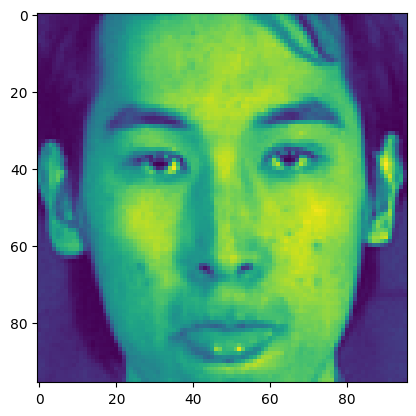

In [20]:
import matplotlib.pyplot as plt
plt.imshow(X_train[8])
plt.show()

Metrics

In [21]:
precision = keras.metrics.Precision(name="Precision")
recall = keras.metrics.Recall(name="Recall")


SVM

Simple CNN

In [208]:
# Suggested by tensorflow
simplecnn = Sequential()
simplecnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(size, size, 1), batch_size=4))
simplecnn.add(MaxPooling2D((2, 2)))
simplecnn.add(Conv2D(64, (3, 3), activation='relu'))
simplecnn.add(MaxPooling2D((2, 2)))
simplecnn.add(Conv2D(64, (3, 3), activation='relu'))
simplecnn.add(Flatten())
simplecnn.add(Dense(units=1024, kernel_regularizer=regularizer))
simplecnn.add(BatchNormalization(scale=False,
                                   center=False))
simplecnn.add(Activation('relu'))
simplecnn.add(Dropout(rate=0.4))
simplecnn.add(Dense(units=num_classes, activation="softmax",kernel_regularizer=regularizer)) 


In [209]:
import datetime
folder_name = 'logs/SimpleCNN'+dataset_name
log_folder = folder_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [210]:
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath='./chkpts/SimpleCNN'+dataset_name,monitor='val_custom_f1', mode='max',save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max',patience=2)
#The callbacks list now becomes:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_folder)
callbacks=[model_checkpoint_cb, tensorboard_callback]

In [211]:
simplecnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[precision,recall,custom_f1, auc_metric,'accuracy'])

In [212]:
history_simplecnn = simplecnn.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=NUM_EPOCHS,
callbacks=callbacks, batch_size=4)

Epoch 1/20
198/198 [==============================] - ETA: 0s - loss: 0.9224 - Precision: 0.3664 - Recall: 0.0271 - custom_f1: 0.0492 - auc: 0.5517 - accuracy: 0.1698

INFO:tensorflow:Assets written to: ./chkpts/SimpleCNNMMI_FACS/assets


INFO:tensorflow:Assets written to: ./chkpts/SimpleCNNMMI_FACS/assets


198/198 [==============================] - 10s 37ms/step - loss: 0.9224 - Precision: 0.3664 - Recall: 0.0271 - custom_f1: 0.0492 - auc: 0.5517 - accuracy: 0.1698 - val_loss: 0.6683 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_custom_f1: 0.0000e+00 - val_auc: 0.6450 - val_accuracy: 0.0202
Epoch 2/20
196/198 [============================>.] - ETA: 0s - loss: 0.5422 - Precision: 0.4474 - Recall: 0.0193 - custom_f1: 0.0346 - auc: 0.6948 - accuracy: 0.2066

INFO:tensorflow:Assets written to: ./chkpts/SimpleCNNMMI_FACS/assets


INFO:tensorflow:Assets written to: ./chkpts/SimpleCNNMMI_FACS/assets


198/198 [==============================] - 7s 36ms/step - loss: 0.5417 - Precision: 0.4545 - Recall: 0.0198 - custom_f1: 0.0357 - auc: 0.6950 - accuracy: 0.2079 - val_loss: 0.7052 - val_Precision: 0.4362 - val_Recall: 0.1847 - val_custom_f1: 0.2574 - val_auc: 0.7104 - val_accuracy: 0.1717
Epoch 3/20
198/198 [==============================] - 5s 23ms/step - loss: 0.4885 - Precision: 0.3788 - Recall: 0.0141 - custom_f1: 0.0268 - auc: 0.7076 - accuracy: 0.1825 - val_loss: 0.5230 - val_Precision: 0.3838 - val_Recall: 0.1712 - val_custom_f1: 0.2368 - val_auc: 0.7150 - val_accuracy: 0.1616
Epoch 4/20
198/198 [==============================] - 5s 23ms/step - loss: 0.4646 - Precision: 0.3871 - Recall: 0.0068 - custom_f1: 0.0126 - auc: 0.7134 - accuracy: 0.1939 - val_loss: 0.9849 - val_Precision: 0.4022 - val_Recall: 0.1667 - val_custom_f1: 0.2244 - val_auc: 0.6563 - val_accuracy: 0.1313
Epoch 5/20
198/198 [==============================] - ETA: 0s - loss: 0.4572 - Precision: 0.4250 - Recall: 0

INFO:tensorflow:Assets written to: ./chkpts/SimpleCNNMMI_FACS/assets


INFO:tensorflow:Assets written to: ./chkpts/SimpleCNNMMI_FACS/assets


198/198 [==============================] - 7s 36ms/step - loss: 0.4572 - Precision: 0.4250 - Recall: 0.0096 - custom_f1: 0.0172 - auc: 0.7183 - accuracy: 0.1990 - val_loss: 1.1277 - val_Precision: 0.4421 - val_Recall: 0.1892 - val_custom_f1: 0.2636 - val_auc: 0.6780 - val_accuracy: 0.1717
Epoch 6/20
198/198 [==============================] - 5s 23ms/step - loss: 0.4557 - Precision: 0.3333 - Recall: 0.0056 - custom_f1: 0.0121 - auc: 0.7149 - accuracy: 0.1926 - val_loss: 0.6368 - val_Precision: 0.4800 - val_Recall: 0.1622 - val_custom_f1: 0.2449 - val_auc: 0.6959 - val_accuracy: 0.1919
Epoch 7/20
198/198 [==============================] - ETA: 0s - loss: 0.4445 - Precision: 0.4800 - Recall: 0.0068 - custom_f1: 0.0129 - auc: 0.7152 - accuracy: 0.1850

INFO:tensorflow:Assets written to: ./chkpts/SimpleCNNMMI_FACS/assets


INFO:tensorflow:Assets written to: ./chkpts/SimpleCNNMMI_FACS/assets


198/198 [==============================] - 8s 38ms/step - loss: 0.4445 - Precision: 0.4800 - Recall: 0.0068 - custom_f1: 0.0129 - auc: 0.7152 - accuracy: 0.1850 - val_loss: 1.9057 - val_Precision: 0.4444 - val_Recall: 0.1982 - val_custom_f1: 0.2755 - val_auc: 0.6415 - val_accuracy: 0.1717
Epoch 8/20
198/198 [==============================] - 5s 23ms/step - loss: 0.4373 - Precision: 0.3182 - Recall: 0.0040 - custom_f1: 0.0061 - auc: 0.7207 - accuracy: 0.1838 - val_loss: 0.8372 - val_Precision: 0.3838 - val_Recall: 0.1712 - val_custom_f1: 0.2368 - val_auc: 0.6653 - val_accuracy: 0.1616
Epoch 9/20
198/198 [==============================] - 5s 23ms/step - loss: 0.4379 - Precision: 0.3043 - Recall: 0.0040 - custom_f1: 0.0082 - auc: 0.7212 - accuracy: 0.1863 - val_loss: 1.5471 - val_Precision: 0.3789 - val_Recall: 0.1622 - val_custom_f1: 0.2215 - val_auc: 0.6555 - val_accuracy: 0.1616
Epoch 10/20
198/198 [==============================] - 5s 23ms/step - loss: 0.4546 - Precision: 0.4500 - Rec

VGG16

In [27]:
device = cuda.get_current_device()
device.reset()

In [213]:
vgg16_model = VGG16(include_top=False, weights='imagenet')
vgg16_updated = change_input_layer(vgg16_model, 1, size, size, 1)

['input_3', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(4, 96, 96, 1)]          0         
                                                                 
 block1_conv1 (Conv2D)       (4, 96, 96, 64)           640       
                                                                 
 block1_conv2 (Conv2D)       (4, 96, 96, 64)           36928     
                                                                 
 block1_pool (MaxPooling2D)  (4, 48, 48, 64)           0         
                                                                 
 block2_conv1 (Conv2D)       (

In [214]:
final_vgg16 = Sequential()
final_vgg16.add(vgg16_updated)
final_vgg16.add(Flatten())
final_vgg16.add(Dense(units=1024, kernel_regularizer=regularizer))
final_vgg16.add(BatchNormalization(scale=False,
                                   center=False))
final_vgg16.add(Activation('relu'))
final_vgg16.add(Dropout(rate=0.4))
final_vgg16.add(Dense(units=num_classes, activation="softmax",kernel_regularizer=regularizer)) 


In [215]:
import datetime
folder_name = 'logs/VGG16'+dataset_name
log_folder = folder_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [216]:
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath='./chkpts/VGG16'+dataset_name,monitor='val_custom_f1', mode='max',save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max',patience=2)
#The callbacks list now becomes:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_folder)
callbacks=[model_checkpoint_cb, tensorboard_callback]

In [217]:
final_vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=[precision,recall,custom_f1, auc_metric,'accuracy'])

In [218]:
history_vgg16 = final_vgg16.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=NUM_EPOCHS,
callbacks=callbacks, batch_size=4)

Epoch 1/20
198/198 [==============================] - ETA: 0s - loss: 1.0133 - Precision: 0.4096 - Recall: 0.0773 - custom_f1: 0.1080 - auc: 0.6586 - accuracy: 0.1610

2023-04-13 20:34:10.607863: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-13 20:34:10.644628: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-13 20:34:11.950143: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-13 20:34:11.989694: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU

INFO:tensorflow:Assets written to: ./chkpts/VGG16MMI_FACS/assets


INFO:tensorflow:Assets written to: ./chkpts/VGG16MMI_FACS/assets


198/198 [==============================] - 10s 44ms/step - loss: 1.0133 - Precision: 0.4096 - Recall: 0.0773 - custom_f1: 0.1080 - auc: 0.6586 - accuracy: 0.1610 - val_loss: 0.8523 - val_Precision: 0.4684 - val_Recall: 0.1667 - val_custom_f1: 0.2389 - val_auc: 0.6343 - val_accuracy: 0.1616
Epoch 2/20
198/198 [==============================] - 5s 23ms/step - loss: 0.7255 - Precision: 0.4126 - Recall: 0.0480 - custom_f1: 0.0849 - auc: 0.6663 - accuracy: 0.1432 - val_loss: 0.7403 - val_Precision: 0.3714 - val_Recall: 0.0586 - val_custom_f1: 0.0929 - val_auc: 0.6498 - val_accuracy: 0.1515
Epoch 3/20
198/198 [==============================] - 5s 23ms/step - loss: 0.6344 - Precision: 0.4039 - Recall: 0.0463 - custom_f1: 0.0794 - auc: 0.6807 - accuracy: 0.1610 - val_loss: 0.7387 - val_Precision: 0.3537 - val_Recall: 0.1306 - val_custom_f1: 0.1736 - val_auc: 0.6362 - val_accuracy: 0.1818
Epoch 4/20
198/198 [==============================] - 5s 23ms/step - loss: 0.5871 - Precision: 0.4767 - Rec

VGG19

In [31]:
device = cuda.get_current_device()
device.reset()

In [219]:
pretrained_model = VGG19(include_top=False, weights='imagenet')


In [220]:
vgg19_model = VGG19(include_top=False, weights='imagenet')
vgg19_updated = change_input_layer(vgg19_model, 1, size, size, 1)

['input_5', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_conv4', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_conv4', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool']
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(4, 96, 96, 1)]          0         
                                                                 
 block1_conv1 (Conv2D)       (4, 96, 96, 64)           640       
                                                                 
 block1_conv2 (Conv2D)       (4, 96, 96, 64)           36928     
                                                                 
 block1_pool (MaxPooling2D)  (4, 48, 48, 64)           0         
                                                

In [221]:
final_vgg19 = Sequential()
final_vgg19.add(vgg19_updated)
final_vgg19.add(Flatten())
final_vgg19.add(Dense(units=1024, kernel_regularizer=regularizer))
final_vgg19.add(BatchNormalization(scale=False,
                                   center=False))
final_vgg19.add(Activation('relu'))
final_vgg19.add(Dropout(rate=0.4))
final_vgg19.add(Dense(units=num_classes, activation="softmax",kernel_regularizer=regularizer)) 

In [222]:
import datetime
folder_name = 'logs/VGG19'+dataset_name
log_folder = folder_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [223]:
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath='./chkpts/VGG19'+dataset_name,monitor='val_custom_f1', mode='max',save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max',patience=2)
#The callbacks list now becomes:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_folder)
callbacks=[model_checkpoint_cb, tensorboard_callback]

In [224]:
final_vgg19.compile(optimizer='adam', loss='binary_crossentropy', metrics=[precision,recall,custom_f1, auc_metric,'accuracy'])

In [225]:
history_vgg19 = final_vgg19.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=NUM_EPOCHS,
callbacks=callbacks, batch_size=4)

Epoch 1/20
197/198 [============================>.] - ETA: 0s - loss: 1.0397 - Precision: 0.4000 - Recall: 0.0582 - custom_f1: 0.1026 - auc: 0.6455 - accuracy: 0.1485

INFO:tensorflow:Assets written to: ./chkpts/VGG19MMI_FACS/assets


INFO:tensorflow:Assets written to: ./chkpts/VGG19MMI_FACS/assets


198/198 [==============================] - 12s 49ms/step - loss: 1.0398 - Precision: 0.4000 - Recall: 0.0582 - custom_f1: 0.1021 - auc: 0.6453 - accuracy: 0.1483 - val_loss: 0.8934 - val_Precision: 0.1176 - val_Recall: 0.0090 - val_custom_f1: 0.0153 - val_auc: 0.6139 - val_accuracy: 0.1414
Epoch 2/20
197/198 [============================>.] - ETA: 0s - loss: 0.7184 - Precision: 0.4633 - Recall: 0.0571 - custom_f1: 0.0945 - auc: 0.6592 - accuracy: 0.1523

INFO:tensorflow:Assets written to: ./chkpts/VGG19MMI_FACS/assets


INFO:tensorflow:Assets written to: ./chkpts/VGG19MMI_FACS/assets


198/198 [==============================] - 9s 46ms/step - loss: 0.7187 - Precision: 0.4633 - Recall: 0.0570 - custom_f1: 0.0940 - auc: 0.6590 - accuracy: 0.1534 - val_loss: 0.6937 - val_Precision: 0.4571 - val_Recall: 0.1441 - val_custom_f1: 0.2126 - val_auc: 0.6855 - val_accuracy: 0.1717
Epoch 3/20
198/198 [==============================] - 6s 29ms/step - loss: 0.6290 - Precision: 0.4279 - Recall: 0.0503 - custom_f1: 0.0846 - auc: 0.6697 - accuracy: 0.1711 - val_loss: 0.6392 - val_Precision: 0.4583 - val_Recall: 0.0495 - val_custom_f1: 0.0936 - val_auc: 0.6713 - val_accuracy: 0.1313
Epoch 4/20
198/198 [==============================] - 6s 29ms/step - loss: 0.5916 - Precision: 0.3486 - Recall: 0.0344 - custom_f1: 0.0576 - auc: 0.6770 - accuracy: 0.1394 - val_loss: 0.6779 - val_Precision: 0.3750 - val_Recall: 0.1486 - val_custom_f1: 0.2098 - val_auc: 0.6222 - val_accuracy: 0.1616
Epoch 5/20
198/198 [==============================] - 6s 29ms/step - loss: 0.5620 - Precision: 0.4895 - Reca

INFO:tensorflow:Assets written to: ./chkpts/VGG19MMI_FACS/assets


INFO:tensorflow:Assets written to: ./chkpts/VGG19MMI_FACS/assets


198/198 [==============================] - 9s 46ms/step - loss: 0.5301 - Precision: 0.4031 - Recall: 0.0294 - custom_f1: 0.0473 - auc: 0.6867 - accuracy: 0.1572 - val_loss: 0.5846 - val_Precision: 0.4375 - val_Recall: 0.1577 - val_custom_f1: 0.2203 - val_auc: 0.6759 - val_accuracy: 0.1717
Epoch 12/20
198/198 [==============================] - 6s 29ms/step - loss: 0.5255 - Precision: 0.3165 - Recall: 0.0141 - custom_f1: 0.0258 - auc: 0.6828 - accuracy: 0.1496 - val_loss: 0.6116 - val_Precision: 0.5556 - val_Recall: 0.0901 - val_custom_f1: 0.1640 - val_auc: 0.6941 - val_accuracy: 0.1616
Epoch 13/20
198/198 [==============================] - 6s 29ms/step - loss: 0.5264 - Precision: 0.4557 - Recall: 0.0203 - custom_f1: 0.0340 - auc: 0.6736 - accuracy: 0.1673 - val_loss: 0.5608 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_custom_f1: 0.0000e+00 - val_auc: 0.6499 - val_accuracy: 0.1515
Epoch 14/20
198/198 [==============================] - 6s 29ms/step - loss: 0.5204 - Precision

INFO:tensorflow:Assets written to: ./chkpts/VGG19MMI_FACS/assets


INFO:tensorflow:Assets written to: ./chkpts/VGG19MMI_FACS/assets


198/198 [==============================] - 9s 45ms/step - loss: 0.5163 - Precision: 0.4388 - Recall: 0.0243 - custom_f1: 0.0435 - auc: 0.6907 - accuracy: 0.1610 - val_loss: 0.6156 - val_Precision: 0.4459 - val_Recall: 0.1486 - val_custom_f1: 0.2212 - val_auc: 0.6621 - val_accuracy: 0.1616
Epoch 19/20
198/198 [==============================] - 6s 28ms/step - loss: 0.5222 - Precision: 0.4815 - Recall: 0.0294 - custom_f1: 0.0546 - auc: 0.6868 - accuracy: 0.1724 - val_loss: 0.5943 - val_Precision: 0.3514 - val_Recall: 0.1171 - val_custom_f1: 0.1776 - val_auc: 0.6694 - val_accuracy: 0.1717
Epoch 20/20
198/198 [==============================] - 6s 29ms/step - loss: 0.5112 - Precision: 0.4286 - Recall: 0.0152 - custom_f1: 0.0282 - auc: 0.6919 - accuracy: 0.1622 - val_loss: 0.5890 - val_Precision: 0.4000 - val_Recall: 0.1261 - val_custom_f1: 0.1862 - val_auc: 0.6662 - val_accuracy: 0.1616


ResNet

In [ ]:
device = cuda.get_current_device()
device.reset()

In [226]:
resnet_model = ResNet101(include_top=False, weights='imagenet')
resnet_model.summary()
resnet_updated = change_input_layer(resnet_model, 2, size, size, 1)
resnet_updated.trainable = True

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_6[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                       

In [227]:
resnet_updated.trainable = False
final_resnet = Sequential()
final_resnet.add(resnet_updated)
final_resnet.add(Flatten())
final_resnet.add(Dense(units=1024, kernel_regularizer=regularizer))
final_resnet.add(BatchNormalization(scale=False,
                                   center=False))
final_resnet.add(Activation('relu'))
final_resnet.add(Dropout(rate=0.4))
final_resnet.add(Dense(units=num_classes, activation="softmax",kernel_regularizer=regularizer)) 

In [228]:
folder_name = 'logs/ResNet'+dataset_name
log_folder = folder_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [229]:
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath='./chkpts/ResNet'+dataset_name,monitor='val_custom_f1', mode='max',save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max',patience=2)
#The callbacks list now becomes:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_folder)
callbacks=[model_checkpoint_cb, tensorboard_callback]

In [230]:
final_resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=[precision,recall,custom_f1, auc_metric,'accuracy'])

In [231]:
history_resnet = final_resnet.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=NUM_EPOCHS,
callbacks=callbacks, batch_size=4)

Epoch 1/20


2023-04-13 20:39:50.563520: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 296.50MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-13 20:39:50.781987: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


197/198 [============================>.] - ETA: 0s - loss: 0.5808 - Precision: 0.3566 - Recall: 0.0514 - custom_f1: 0.0701 - auc: 0.6530 - accuracy: 0.1320

2023-04-13 20:40:00.232616: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 290.12MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-13 20:40:00.413388: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


198/198 [==============================] - ETA: 0s - loss: 0.5810 - Precision: 0.3566 - Recall: 0.0512 - custom_f1: 0.0697 - auc: 0.6533 - accuracy: 0.1318

2023-04-13 20:40:04.550787: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


INFO:tensorflow:Assets written to: ./chkpts/ResNetMMI_FACS/assets


INFO:tensorflow:Assets written to: ./chkpts/ResNetMMI_FACS/assets


198/198 [==============================] - 60s 265ms/step - loss: 0.5810 - Precision: 0.3566 - Recall: 0.0512 - custom_f1: 0.0697 - auc: 0.6533 - accuracy: 0.1318 - val_loss: 0.6301 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_custom_f1: 0.0000e+00 - val_auc: 0.6121 - val_accuracy: 0.0303
Epoch 2/20
197/198 [============================>.] - ETA: 0s - loss: 0.4873 - Precision: 0.3972 - Recall: 0.0316 - custom_f1: 0.0534 - auc: 0.6777 - accuracy: 0.1536

INFO:tensorflow:Assets written to: ./chkpts/ResNetMMI_FACS/assets


INFO:tensorflow:Assets written to: ./chkpts/ResNetMMI_FACS/assets


198/198 [==============================] - 47s 240ms/step - loss: 0.4876 - Precision: 0.3972 - Recall: 0.0316 - custom_f1: 0.0531 - auc: 0.6775 - accuracy: 0.1534 - val_loss: 0.8904 - val_Precision: 0.1304 - val_Recall: 0.0541 - val_custom_f1: 0.0694 - val_auc: 0.6314 - val_accuracy: 0.1313
Epoch 3/20
198/198 [==============================] - ETA: 0s - loss: 0.4819 - Precision: 0.3406 - Recall: 0.0265 - custom_f1: 0.0457 - auc: 0.6819 - accuracy: 0.1483

INFO:tensorflow:Assets written to: ./chkpts/ResNetMMI_FACS/assets


INFO:tensorflow:Assets written to: ./chkpts/ResNetMMI_FACS/assets


198/198 [==============================] - 48s 241ms/step - loss: 0.4819 - Precision: 0.3406 - Recall: 0.0265 - custom_f1: 0.0457 - auc: 0.6819 - accuracy: 0.1483 - val_loss: 1.6109 - val_Precision: 0.3838 - val_Recall: 0.1712 - val_custom_f1: 0.2368 - val_auc: 0.5837 - val_accuracy: 0.1616
Epoch 4/20
198/198 [==============================] - 9s 48ms/step - loss: 0.4673 - Precision: 0.4409 - Recall: 0.0316 - custom_f1: 0.0579 - auc: 0.6946 - accuracy: 0.1749 - val_loss: 1.6183 - val_Precision: 0.1616 - val_Recall: 0.0721 - val_custom_f1: 0.1038 - val_auc: 0.5225 - val_accuracy: 0.1212
Epoch 5/20
198/198 [==============================] - 9s 48ms/step - loss: 0.4558 - Precision: 0.4516 - Recall: 0.0316 - custom_f1: 0.0553 - auc: 0.6993 - accuracy: 0.1914 - val_loss: 1.7955 - val_Precision: 0.1237 - val_Recall: 0.0541 - val_custom_f1: 0.0719 - val_auc: 0.4932 - val_accuracy: 0.0303
Epoch 6/20
198/198 [==============================] - ETA: 0s - loss: 0.4605 - Precision: 0.4766 - Recall:

INFO:tensorflow:Assets written to: ./chkpts/ResNetMMI_FACS/assets


INFO:tensorflow:Assets written to: ./chkpts/ResNetMMI_FACS/assets


198/198 [==============================] - 47s 236ms/step - loss: 0.4605 - Precision: 0.4766 - Recall: 0.0288 - custom_f1: 0.0528 - auc: 0.6853 - accuracy: 0.1812 - val_loss: 1.5445 - val_Precision: 0.4526 - val_Recall: 0.1937 - val_custom_f1: 0.2714 - val_auc: 0.6241 - val_accuracy: 0.1818
Epoch 7/20
198/198 [==============================] - ETA: 0s - loss: 0.4536 - Precision: 0.4722 - Recall: 0.0288 - custom_f1: 0.0548 - auc: 0.7038 - accuracy: 0.1825

INFO:tensorflow:Assets written to: ./chkpts/ResNetMMI_FACS/assets


INFO:tensorflow:Assets written to: ./chkpts/ResNetMMI_FACS/assets


198/198 [==============================] - 47s 236ms/step - loss: 0.4536 - Precision: 0.4722 - Recall: 0.0288 - custom_f1: 0.0548 - auc: 0.7038 - accuracy: 0.1825 - val_loss: 1.9756 - val_Precision: 0.4444 - val_Recall: 0.1982 - val_custom_f1: 0.2755 - val_auc: 0.5789 - val_accuracy: 0.1717
Epoch 8/20
198/198 [==============================] - 9s 48ms/step - loss: 0.4511 - Precision: 0.4245 - Recall: 0.0254 - custom_f1: 0.0476 - auc: 0.6962 - accuracy: 0.1876 - val_loss: 1.6389 - val_Precision: 0.4444 - val_Recall: 0.1982 - val_custom_f1: 0.2755 - val_auc: 0.5836 - val_accuracy: 0.1717
Epoch 9/20
198/198 [==============================] - 9s 48ms/step - loss: 0.4406 - Precision: 0.4035 - Recall: 0.0260 - custom_f1: 0.0482 - auc: 0.7039 - accuracy: 0.1660 - val_loss: 2.3274 - val_Precision: 0.3838 - val_Recall: 0.1712 - val_custom_f1: 0.2368 - val_auc: 0.6413 - val_accuracy: 0.1616
Epoch 10/20
198/198 [==============================] - 9s 48ms/step - loss: 0.4417 - Precision: 0.3976 - R

INFO:tensorflow:Assets written to: ./chkpts/ResNetMMI_FACS/assets


INFO:tensorflow:Assets written to: ./chkpts/ResNetMMI_FACS/assets


198/198 [==============================] - 46s 236ms/step - loss: 0.4422 - Precision: 0.4337 - Recall: 0.0203 - custom_f1: 0.0358 - auc: 0.6954 - accuracy: 0.1711 - val_loss: 1.8212 - val_Precision: 0.4545 - val_Recall: 0.2027 - val_custom_f1: 0.2816 - val_auc: 0.6437 - val_accuracy: 0.1818
Epoch 15/20
198/198 [==============================] - 9s 48ms/step - loss: 0.4351 - Precision: 0.4211 - Recall: 0.0181 - custom_f1: 0.0326 - auc: 0.7012 - accuracy: 0.1762 - val_loss: 2.7683 - val_Precision: 0.4433 - val_Recall: 0.1937 - val_custom_f1: 0.2715 - val_auc: 0.5964 - val_accuracy: 0.1818
Epoch 16/20
198/198 [==============================] - 9s 48ms/step - loss: 0.4369 - Precision: 0.3731 - Recall: 0.0141 - custom_f1: 0.0261 - auc: 0.7028 - accuracy: 0.1673 - val_loss: 2.0099 - val_Precision: 0.3838 - val_Recall: 0.1712 - val_custom_f1: 0.2368 - val_auc: 0.5634 - val_accuracy: 0.1616
Epoch 17/20
198/198 [==============================] - 10s 48ms/step - loss: 0.4391 - Precision: 0.4040 

DenseNet

In [ ]:
device = cuda.get_current_device()
device.reset()

In [232]:
densenet_model = DenseNet121(include_top=False, weights='imagenet')
densenet_updated = change_input_layer_dense(densenet_model, 2, size, size, 1)

['input_7', 'zero_padding2d', 'conv1/conv', 'conv1/bn', 'conv1/relu', 'zero_padding2d_1', 'pool1', 'conv2_block1_0_bn', 'conv2_block1_0_relu', 'conv2_block1_1_conv', 'conv2_block1_1_bn', 'conv2_block1_1_relu', 'conv2_block1_2_conv', 'conv2_block1_concat', 'conv2_block2_0_bn', 'conv2_block2_0_relu', 'conv2_block2_1_conv', 'conv2_block2_1_bn', 'conv2_block2_1_relu', 'conv2_block2_2_conv', 'conv2_block2_concat', 'conv2_block3_0_bn', 'conv2_block3_0_relu', 'conv2_block3_1_conv', 'conv2_block3_1_bn', 'conv2_block3_1_relu', 'conv2_block3_2_conv', 'conv2_block3_concat', 'conv2_block4_0_bn', 'conv2_block4_0_relu', 'conv2_block4_1_conv', 'conv2_block4_1_bn', 'conv2_block4_1_relu', 'conv2_block4_2_conv', 'conv2_block4_concat', 'conv2_block5_0_bn', 'conv2_block5_0_relu', 'conv2_block5_1_conv', 'conv2_block5_1_bn', 'conv2_block5_1_relu', 'conv2_block5_2_conv', 'conv2_block5_concat', 'conv2_block6_0_bn', 'conv2_block6_0_relu', 'conv2_block6_1_conv', 'conv2_block6_1_bn', 'conv2_block6_1_relu', 'conv

In [233]:
final_densenet = Sequential()
final_densenet.add(densenet_updated)
final_densenet.add(Flatten())
final_densenet.add(Dense(units=1024, kernel_regularizer=regularizer))
final_densenet.add(BatchNormalization(scale=False,
                                   center=False))
final_densenet.add(Activation('relu'))
final_densenet.add(Dropout(rate=0.4))
final_densenet.add(Dense(units=num_classes, activation="softmax",kernel_regularizer=regularizer)) 

In [234]:
folder_name = 'logs/DenseNet'+dataset_name
log_folder = folder_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [235]:
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath='./chkpts/DenseNet'+dataset_name,monitor='val_custom_f1', mode='max',save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max',patience=2)
#The callbacks list now becomes:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_folder)
callbacks=[model_checkpoint_cb, tensorboard_callback]

In [236]:
final_densenet.compile(optimizer='adam', loss='binary_crossentropy', metrics=[precision,recall,custom_f1, auc_metric,'accuracy'])

In [237]:
history_densenet = final_densenet.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=NUM_EPOCHS,
callbacks=callbacks, batch_size=4)

Epoch 1/20


2023-04-13 20:50:55.221856: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 156.31MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


198/198 [==============================] - ETA: 0s - loss: 1.1048 - Precision: 0.4298 - Recall: 0.0783 - custom_f1: 0.1105 - auc: 0.6479 - accuracy: 0.1407

INFO:tensorflow:Assets written to: ./chkpts/DenseNetMMI_FACS/assets


INFO:tensorflow:Assets written to: ./chkpts/DenseNetMMI_FACS/assets


198/198 [==============================] - 60s 256ms/step - loss: 1.1048 - Precision: 0.4298 - Recall: 0.0783 - custom_f1: 0.1105 - auc: 0.6479 - accuracy: 0.1407 - val_loss: 0.9860 - val_Precision: 0.2078 - val_Recall: 0.0721 - val_custom_f1: 0.0920 - val_auc: 0.6214 - val_accuracy: 0.0808
Epoch 2/20
197/198 [============================>.] - ETA: 0s - loss: 0.7638 - Precision: 0.4293 - Recall: 0.0463 - custom_f1: 0.0802 - auc: 0.6695 - accuracy: 0.1650

INFO:tensorflow:Assets written to: ./chkpts/DenseNetMMI_FACS/assets


INFO:tensorflow:Assets written to: ./chkpts/DenseNetMMI_FACS/assets


198/198 [==============================] - 46s 235ms/step - loss: 0.7641 - Precision: 0.4293 - Recall: 0.0463 - custom_f1: 0.0798 - auc: 0.6693 - accuracy: 0.1660 - val_loss: 0.8069 - val_Precision: 0.2833 - val_Recall: 0.0766 - val_custom_f1: 0.1222 - val_auc: 0.6523 - val_accuracy: 0.1515
Epoch 3/20
198/198 [==============================] - 6s 31ms/step - loss: 0.6830 - Precision: 0.4550 - Recall: 0.0514 - custom_f1: 0.0928 - auc: 0.6801 - accuracy: 0.1584 - val_loss: 0.7429 - val_Precision: 0.1154 - val_Recall: 0.0135 - val_custom_f1: 0.0187 - val_auc: 0.6503 - val_accuracy: 0.0707
Epoch 4/20
197/198 [============================>.] - ETA: 0s - loss: 0.6557 - Precision: 0.4639 - Recall: 0.0435 - custom_f1: 0.0765 - auc: 0.6924 - accuracy: 0.1701

INFO:tensorflow:Assets written to: ./chkpts/DenseNetMMI_FACS/assets


INFO:tensorflow:Assets written to: ./chkpts/DenseNetMMI_FACS/assets


198/198 [==============================] - 46s 235ms/step - loss: 0.6561 - Precision: 0.4639 - Recall: 0.0435 - custom_f1: 0.0761 - auc: 0.6922 - accuracy: 0.1698 - val_loss: 0.7061 - val_Precision: 0.4600 - val_Recall: 0.1036 - val_custom_f1: 0.1701 - val_auc: 0.6954 - val_accuracy: 0.1818
Epoch 5/20
198/198 [==============================] - 6s 31ms/step - loss: 0.6428 - Precision: 0.4278 - Recall: 0.0435 - custom_f1: 0.0750 - auc: 0.6872 - accuracy: 0.1698 - val_loss: 0.6967 - val_Precision: 0.3824 - val_Recall: 0.0586 - val_custom_f1: 0.0887 - val_auc: 0.6806 - val_accuracy: 0.1414
Epoch 6/20
198/198 [==============================] - 6s 31ms/step - loss: 0.6334 - Precision: 0.4564 - Recall: 0.0384 - custom_f1: 0.0634 - auc: 0.6815 - accuracy: 0.1660 - val_loss: 0.6847 - val_Precision: 0.5455 - val_Recall: 0.0270 - val_custom_f1: 0.0499 - val_auc: 0.6183 - val_accuracy: 0.1111
Epoch 7/20
198/198 [==============================] - 6s 31ms/step - loss: 0.6185 - Precision: 0.4834 - Re

INFO:tensorflow:Assets written to: ./chkpts/DenseNetMMI_FACS/assets


INFO:tensorflow:Assets written to: ./chkpts/DenseNetMMI_FACS/assets


198/198 [==============================] - 47s 238ms/step - loss: 0.5953 - Precision: 0.4806 - Recall: 0.0350 - custom_f1: 0.0612 - auc: 0.6932 - accuracy: 0.1774 - val_loss: 0.6497 - val_Precision: 0.4545 - val_Recall: 0.1802 - val_custom_f1: 0.2582 - val_auc: 0.6722 - val_accuracy: 0.1717
Epoch 13/20
198/198 [==============================] - 5s 26ms/step - loss: 0.5945 - Precision: 0.4513 - Recall: 0.0288 - custom_f1: 0.0534 - auc: 0.6919 - accuracy: 0.1686 - val_loss: 0.6585 - val_Precision: 0.4259 - val_Recall: 0.1036 - val_custom_f1: 0.1696 - val_auc: 0.6946 - val_accuracy: 0.1717
Epoch 14/20
198/198 [==============================] - 5s 26ms/step - loss: 0.5932 - Precision: 0.4320 - Recall: 0.0305 - custom_f1: 0.0520 - auc: 0.6860 - accuracy: 0.1724 - val_loss: 0.6599 - val_Precision: 0.4474 - val_Recall: 0.0766 - val_custom_f1: 0.1347 - val_auc: 0.6972 - val_accuracy: 0.1515
Epoch 15/20
198/198 [==============================] - 5s 26ms/step - loss: 0.5849 - Precision: 0.4836 -

Xception

In [238]:
device = cuda.get_current_device()
device.reset()

In [22]:
xception_model = Xception(include_top=False, weights='imagenet')
xception_model.summary()
xception_updated = change_input_layer_dense(xception_model, 1, size, size, 1)

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                        

In [23]:
final_xception = Sequential()
final_xception.add(xception_updated)
final_xception.add(Flatten())
final_xception.add(Dense(units=1024, kernel_regularizer=regularizer))
final_xception.add(BatchNormalization(scale=False,
                                   center=False))
final_xception.add(Activation('relu'))
final_xception.add(Dropout(rate=0.4))
final_xception.add(Dense(units=num_classes, activation="softmax",kernel_regularizer=regularizer)) 

In [24]:
import datetime
folder_name = 'logs/Xception'+dataset_name
log_folder = folder_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [25]:
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath='./chkpts/Xception'+dataset_name,monitor='val_custom_f1', mode='max',save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max',patience=2)
#The callbacks list now becomes:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_folder,
                                                      histogram_freq=1)
callbacks=[model_checkpoint_cb, tensorboard_callback]

In [26]:
final_xception.compile(optimizer='adam', loss='binary_crossentropy', metrics=[precision,recall,custom_f1, auc_metric,'accuracy'])

In [27]:
#tf.config.run_functions_eagerly(False)

In [28]:
history_xception = final_xception.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=NUM_EPOCHS,
callbacks=callbacks,  batch_size=4)

Epoch 1/20


2023-04-13 20:57:22.973387: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-13 20:57:23.582457: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-13 20:57:24.367250: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x20c04730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-13 20:57:24.367283: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 970M, Compute Capability 5.2
2023-04-13 20:57:24.376168: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-13 20:57:24.464382: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-13 20:57:24.524095: I ./tensorflow/compiler/jit/device_compiler

198/198 [==============================] - ETA: 0s - loss: 1.1755 - Precision: 0.3860 - Recall: 0.0621 - custom_f1: 0.1038 - auc: 0.6391 - accuracy: 0.1420

INFO:tensorflow:Assets written to: ./chkpts/XceptionMMI_FACS/assets


INFO:tensorflow:Assets written to: ./chkpts/XceptionMMI_FACS/assets
2023-04-13 20:57:52.225398: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 377487360 exceeds 10% of free system memory.
2023-04-13 20:57:52.493315: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 754974720 exceeds 10% of free system memory.
2023-04-13 20:57:53.169746: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4529848320 exceeds 10% of free system memory.


198/198 [==============================] - 40s 172ms/step - loss: 1.1755 - Precision: 0.3860 - Recall: 0.0621 - custom_f1: 0.1038 - auc: 0.6391 - accuracy: 0.1420 - val_loss: 0.9543 - val_Precision: 0.4889 - val_Recall: 0.0991 - val_custom_f1: 0.1571 - val_auc: 0.6799 - val_accuracy: 0.1616
Epoch 2/20
197/198 [============================>.] - ETA: 0s - loss: 0.8152 - Precision: 0.4000 - Recall: 0.0543 - custom_f1: 0.0958 - auc: 0.6662 - accuracy: 0.1675

INFO:tensorflow:Assets written to: ./chkpts/XceptionMMI_FACS/assets


INFO:tensorflow:Assets written to: ./chkpts/XceptionMMI_FACS/assets
2023-04-13 20:58:24.612100: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 377487360 exceeds 10% of free system memory.
2023-04-13 20:58:24.873112: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 754974720 exceeds 10% of free system memory.


198/198 [==============================] - 29s 148ms/step - loss: 0.8156 - Precision: 0.4000 - Recall: 0.0542 - custom_f1: 0.0953 - auc: 0.6660 - accuracy: 0.1686 - val_loss: 0.8920 - val_Precision: 0.4286 - val_Recall: 0.1757 - val_custom_f1: 0.2415 - val_auc: 0.6496 - val_accuracy: 0.1717
Epoch 3/20
198/198 [==============================] - 13s 68ms/step - loss: 0.7695 - Precision: 0.4640 - Recall: 0.0582 - custom_f1: 0.1022 - auc: 0.6721 - accuracy: 0.1686 - val_loss: 0.8418 - val_Precision: 0.4655 - val_Recall: 0.1216 - val_custom_f1: 0.1836 - val_auc: 0.6071 - val_accuracy: 0.1515
Epoch 4/20
198/198 [==============================] - 13s 67ms/step - loss: 0.7529 - Precision: 0.4256 - Recall: 0.0469 - custom_f1: 0.0803 - auc: 0.6716 - accuracy: 0.1660 - val_loss: 0.7949 - val_Precision: 0.4127 - val_Recall: 0.1171 - val_custom_f1: 0.1758 - val_auc: 0.6948 - val_accuracy: 0.1515
Epoch 5/20
198/198 [==============================] - 13s 67ms/step - loss: 0.7382 - Precision: 0.4511 -

INFO:tensorflow:Assets written to: ./chkpts/XceptionMMI_FACS/assets


INFO:tensorflow:Assets written to: ./chkpts/XceptionMMI_FACS/assets


198/198 [==============================] - 28s 143ms/step - loss: 0.6491 - Precision: 0.3947 - Recall: 0.0169 - custom_f1: 0.0319 - auc: 0.6855 - accuracy: 0.1762 - val_loss: 0.7467 - val_Precision: 0.4556 - val_Recall: 0.1847 - val_custom_f1: 0.2567 - val_auc: 0.6762 - val_accuracy: 0.1717
Epoch 16/20
198/198 [==============================] - 13s 66ms/step - loss: 0.6496 - Precision: 0.4300 - Recall: 0.0243 - custom_f1: 0.0451 - auc: 0.6869 - accuracy: 0.1825 - val_loss: 0.7595 - val_Precision: 0.4179 - val_Recall: 0.1261 - val_custom_f1: 0.1823 - val_auc: 0.6739 - val_accuracy: 0.1414
Epoch 17/20
198/198 [==============================] - 13s 65ms/step - loss: 0.6481 - Precision: 0.3860 - Recall: 0.0248 - custom_f1: 0.0437 - auc: 0.6936 - accuracy: 0.1660 - val_loss: 0.6729 - val_Precision: 0.4342 - val_Recall: 0.1486 - val_custom_f1: 0.2128 - val_auc: 0.6987 - val_accuracy: 0.1515
Epoch 18/20
198/198 [==============================] - 13s 66ms/step - loss: 0.6556 - Precision: 0.386

Testing

In [51]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [76]:
from sklearn.metrics import confusion_matrix

#Predict
y_prediction = final_xception.predict(X_test)
y_prediction = np.argmax(y_prediction, axis=1)
#y_test = np.argmax(y_test, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result2 = confusion_matrix(y_test, y_prediction)


1/1 [==============================] - 2s 2s/step


In [77]:
result2

array([[5, 0, 0, 0, 0, 0],
       [8, 0, 0, 0, 0, 0],
       [6, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0],
       [7, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 0, 0]], dtype=int64)

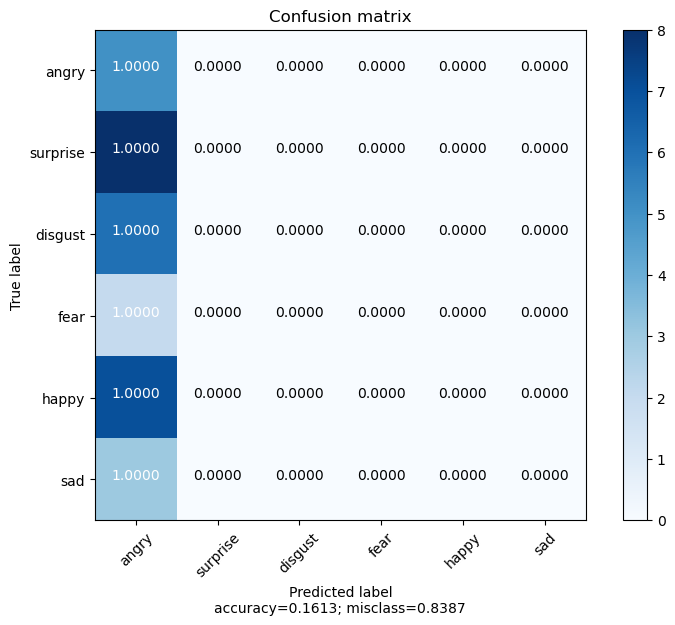

In [78]:
classes = ["angry", "surprise" , "disgust", "fear", "happy", "sad"]
plot_confusion_matrix(result2,classes)